In [1]:
from algorithms import mode_weights_torus
from algorithms import mode_weights
import numpy as np
import matplotlib.pyplot as plt

# Test different surrogate quantities

In [12]:
n_center = 2
dim = 1
centers = np.array([np.array([-1]), np.array([1])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.8, 0.8 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 1000
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.00001
KL_type = 0
bw = ['silverman']*n_center

X_eval = 3 * ((np.arange(400)/400).reshape(-1, 1)*2-1)

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_eval, solver.p_list[0])))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.05s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 57 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.78584592 0.21415408]
Surrogate evaluation at the beginning of the GD: 1.3840124009579498
Real target evaluation at the end of the GD: 0.2673690936728553


In [13]:
def compute_true_ratio(eps):
    n_quad = 1600
    X_quad = ((2*np.arange(n_quad)/n_quad - 1)*4).reshape(-1,1)
    mask = ((nu[0](X_quad) <= eps ) * (X_quad >= -1).reshape(-1)).astype(int)
    return np.sum(nu[1](X_quad)*mask)/np.sum(nu[1](X_quad))

alpha = mode_weights.compute_bandwidth_silverman(X_samples[0])

def select_samples_threshold(eps):
    mask = ((nu[0](X_samples[0]) <= eps ) * (X_samples[0] >= -1).reshape(-1)).astype(int)
    hat_nu_0 = mode_weights.KDE_evaluation(X_samples[0], X_samples[0], alpha)
    num = np.sum(nu[1](X_samples[0]) * mask / hat_nu_0)
    den = np.sum(nu[1](X_samples[0]) / hat_nu_0)
    return num/den


In [16]:
epss = 0.01
print(compute_true_ratio(epss))
print(select_samples_threshold(epss))

0.38322557148596986
0.1647271587633405


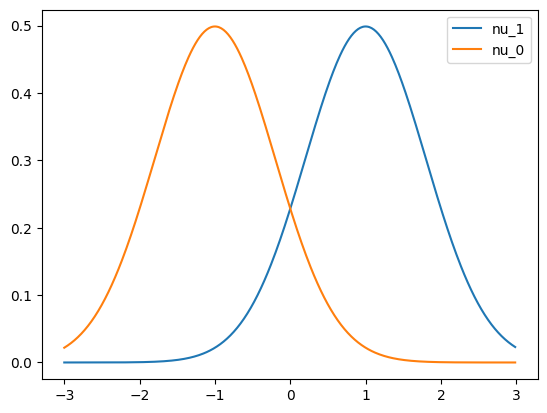

In [ ]:
X_eval = 3 * ((np.arange(400)/400).reshape(-1, 1)*2-1)

plt.plot(X_eval, g(X_eval - 1, 0.8), label='nu_1')
plt.plot(X_eval, g(X_eval + 1, 0.8), label='nu_0')
plt.legend()
plt.show()

In [ ]:

high_args = np.argpartition(X_samples[0].reshape(-1), -10)[-10:]
X_high_args = X_samples[0][high_args]

def hat_nu(X):
    return mode_weights.KDE_evaluation(X_samples[0], X, solver.alpha[0])

def compute_sum(X):
    return np.sum(np.abs(-np.exp(-U(X)) / hat_nu(X)))/len(X_samples[0])

print(compute_sum(X_high_args)/compute_sum(X_samples[0]))
print(10/n_tot)

In [30]:
print(solver.surrogate_function(p0))
print(solver.surrogate_to_objective_1(nu, p0))
print(solver.surrogate_to_objective_2(nu, p0))
print(solver.objective_function(U, nu, X_eval, p0))

1.469235387611762
1.5671515437727725
1.5669629183843687
0.2673690936728553


## Increasing n

Compute $\frac{1}{n} \sum_{i=1}^n \nu(x_i)/\hat{\nu}(x_i)$

In [ ]:

def exponential_density(X, scale):
    return np.exp(-np.abs(X/scale))/(2*scale)

def sample_from_exponential(loc, n_samples, scale):
    X = np.random.exponential(scale, (n_samples, 1)) * (np.random.randint(0, 2, (n_samples, 1))*2 - 1) + loc
    return X

n_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 20000]
for n in n_list:
    X = sample_from_exponential(0, n, 1)#np.random.normal(-1, 0.3, (n, 1))
    bw = mode_weights.compute_bandwidth_silverman(X)

    print('n='+str(n))
    print(np.sum(g(X-1, 0.3) /mode_weights.KDE_evaluation(X, X, bw))/n) # * np.log(0.5*g(X-1, 0.3) + 0.5*g(X+1, 0.3))

n=100
-0.01247655647281279
n=200
-8.91778692858978e-05
n=400
-0.00016761168414253146
n=800
-0.0008219320749952608
n=1600
-0.008689032222703586
n=3200
-0.001437172374997619
n=6400
-0.01565946440286188
n=12800
-0.008074153644219975
n=20000
-0.03587450078918304


In [22]:
X_eval = ((2*np.arange(1000)/1000 - 1)*3).reshape(-1,1)

np.sum(g(X_eval-1, 0.3) * np.log(0.5*g(X_eval-1, 0.3) + 0.5*g(X_eval-1, 0.3)))/len(X_eval)

-0.03582762142648858

# Test exponential law

In [24]:
p_star = [0.75, 0.25]
scale_star = 0.3
locs = [-2, 2]

def sample_from_exponential(loc, n_samples, scale):
    X = np.random.exponential(scale, (n_samples, 1)) * (np.random.randint(0, 2, (n_samples, 1))*2 - 1) + loc
    return X

def exponential_density(X, scale):
    return np.exp(-np.abs(X/scale))

def U(X):
    return - np.log(p_star[0]*exponential_density(X-locs[0], scale_star) + p_star[1]*exponential_density(X-locs[1], scale_star))

nu = []
for i in range(2):
    nu.append(lambda X: exponential_density(X-locs[i], scale_star))


X_samples, U_samples = [], []
n_samples = 1000
for i in range(2):
    X_samples.append(sample_from_exponential(locs[i], n_samples, scale_star))
    U_samples.append(U(X_samples[-1]))


In [25]:
bw = ['cv_ml', 'cv_ml']
KL_type = 0
p0 = np.ones((2))/2
h = 0.0001
eps = 0.00001
max_iter = 100

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)
solver.optimise()

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 1.43s.
Iteration 0
before projection: 
[0.63319479 0.5524416 ]
before projection: 
[0.66414983 0.51604793]
before projection: 
[0.69100155 0.48624403]
before projection: 
[0.71419643 0.46165606]
before projection: 
[0.73413132 0.4413401 ]
before projection: 
[0.75115931 0.42458596]
before projection: 
[0.76560195 0.41082334]
before projection: 
[0.77775829 0.39957441]
before projection: 
[0.78790943 0.3904295 ]
before projection: 
[0.79631959 0.38303459]
before projection: 
[0.80323487 0.37708442]
before projection: 
[0.8088811  0.37231787]
before projection: 
[0.81346191 0.36851406]
before projection: 
[0.81715747 0.36548826]
before projection: 
[0.82012436 0.36308772]
before projection: 
[0.8224964  0.36118731]
before projection: 
[0.82438629 0.35968545]
before projection: 
[0.82588769 0.35850019]
before projection: 
[0.82707767 0.35756581]
before projection: 
[0.82801902 0.35682985]
Iteration 20

In [26]:
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))

Ideal weights: [0.75, 0.25]
Estimated weights: [0.73867059 0.26132941]


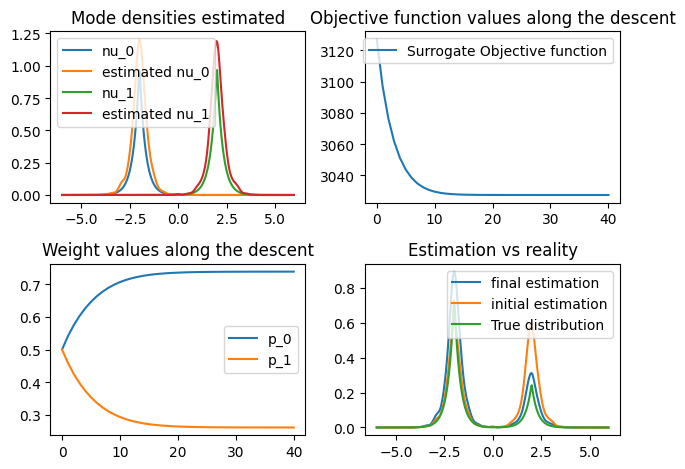

In [27]:


#########################################################################################################################

# Graph display

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
estimated_modes = []
real_modes = []
for i in range(2):
    real_modes.append(nu[i](X_eval))
    estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval, estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(2):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval, y, label='final estimation')
ax[1][1].plot(X_eval, z, label='initial estimation')
ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()

## Torus tests

In [5]:
# Target preparation:

n_center = 2
dim = 1
sigma_min, sigma_max = 0.08, 0.08
centers = np.array([np.array([0.25]), np.array([0.75])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * mode_weights_torus.compute_gaussian_density(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[0], sigma_star[0])

def nu_2(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.array([1/3, 2/3]) # equal
n_tot = 800
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    raw_samples = np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i]
    X_samples.append(np.mod(raw_samples, np.ones((n_samples[i],dim)) ))
    U_samples.append(U(X_samples[-1]))


In [6]:
# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights_torus.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))


Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.34s.
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Gradient descent done ; In 46 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75685011 0.24314989]


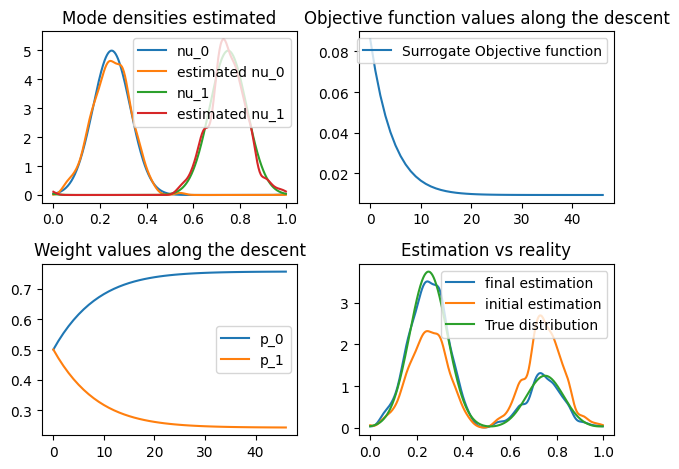

In [7]:
#########################################################################################################################

# Graph display

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = (np.arange(400)/400).reshape(-1, 1)
estimated_modes = []
real_modes = []
for i in range(n_center):
    real_modes.append(nu[i](X_eval))
    estimated_modes.append(mode_weights_torus.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval, estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(n_center):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval, y, label='final estimation')
ax[1][1].plot(X_eval, z, label='initial estimation')
ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()